Text(0.5, 1.0, '2d-regression $w\\in \\{0\\dots 10\\}$')

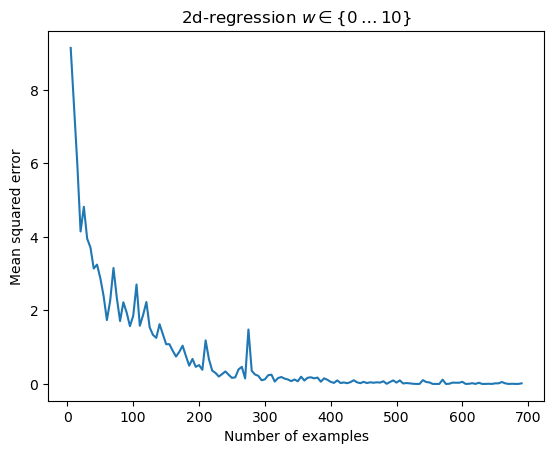

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = 'results/num_examples_{num_examples}.csv'

mses = []
num_examples_range = range(5, 695, 5)
for num_examples in num_examples_range:
    mse = pd.read_csv(path.format(num_examples=num_examples))['mse'].iloc[0]
    mses.append(mse)

plt.plot(num_examples_range, mses)
plt.xlabel('Number of examples')
plt.ylabel('Mean squared error')
plt.title(r'2d-regression $w\in \{0\dots 10\}$')
